# Preparation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
import random
import numbers
import cv2
import math
import numpy as np
from torchvision.transforms import Compose

In [3]:
img = Image.open('../data/test1.jpg')
img2 = Image.open('../data/test2.jpg')

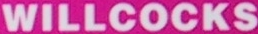

In [4]:
img

In [5]:
img2

# Geometry transformations

In [6]:
def sample_asym(magnitude, size=None):
    return np.random.beta(1, 2, size) * magnitude

def sample_sym(magnitude, size=None):
    return (np.random.beta(2, 2, size=size) - 0.5) * 2 * magnitude

def sample_uniform(low, high, size=None):
    return np.random.uniform(low, high, size=size)

def get_interpolation(type='random'):
    if type == 'random':
        choice = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
        interpolation = choice[random.randint(0, len(choice)-1)]
    elif type == 'nearest': interpolation = cv2.INTER_NEAREST
    elif type == 'linear': interpolation = cv2.INTER_LINEAR
    elif type == 'cubic': interpolation = cv2.INTER_CUBIC
    elif type == 'area': interpolation = cv2.INTER_AREA
    else: raise TypeError('Interpolation types only nearest, linear, cubic, area are supported!')
    return interpolation

# CVRandomRotation

In [7]:
class CVRandomRotation(object):
    def __init__(self, degrees=15):
        assert isinstance(degrees, numbers.Number), "degree should be a single number."
        assert degrees >= 0, "degree must be positive."
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        return sample_sym(degrees)
    
    def __call__(self, img):
        angle = self.get_params(self.degrees)
        src_h, src_w = img.shape[:2]
        M = cv2.getRotationMatrix2D(center=(src_w/2, src_h/2), angle=angle, scale=1.0)
        abs_cos, abs_sin = abs(M[0,0]), abs(M[0,1])
        dst_w = int(src_h * abs_sin + src_w * abs_cos)
        dst_h = int(src_h * abs_cos + src_w * abs_sin)
        M[0, 2] += (dst_w - src_w)/2
        M[1, 2] += (dst_h - src_h)/2
        
        flags = get_interpolation()
        return cv2.warpAffine(img, M, (dst_w, dst_h), flags=flags, borderMode=cv2.BORDER_REPLICATE)


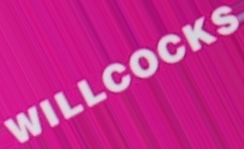

In [8]:
Image.fromarray(CVRandomRotation(45)(np.array(img)))

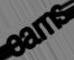

In [9]:
Image.fromarray(CVRandomRotation(45)(np.array(img2)))

# CVRandomAffine

In [10]:
class CVRandomAffine(object):
    def __init__(self, degrees, translate=None, scale=None, shear=None):
        assert isinstance(degrees, numbers.Number), "degree should be a single number."
        assert degrees >= 0, "degree must be positive."
        self.degrees = degrees

        if translate is not None:
            assert isinstance(translate, (tuple, list)) and len(translate) == 2, \
                "translate should be a list or tuple and it must be of length 2."
            for t in translate:
                if not (0.0 <= t <= 1.0):
                    raise ValueError("translation values should be between 0 and 1")
        self.translate = translate

        if scale is not None:
            assert isinstance(scale, (tuple, list)) and len(scale) == 2, \
                "scale should be a list or tuple and it must be of length 2."
            for s in scale:
                if s <= 0:
                    raise ValueError("scale values should be positive")
        self.scale = scale

        if shear is not None:
            if isinstance(shear, numbers.Number):
                if shear < 0:
                    raise ValueError("If shear is a single number, it must be positive.")
                self.shear = [shear]
            else:
                assert isinstance(shear, (tuple, list)) and (len(shear) == 2), \
                    "shear should be a list or tuple and it must be of length 2."
                self.shear = shear
        else:
            self.shear = shear
            
    def _get_inverse_affine_matrix(self, center, angle, translate, scale, shear):
        # https://github.com/pytorch/vision/blob/v0.4.0/torchvision/transforms/functional.py#L717
        from numpy import sin, cos, tan
        
        if isinstance(shear, numbers.Number):
            shear = [shear, 0]

        if not isinstance(shear, (tuple, list)) and len(shear) == 2:
            raise ValueError(
                "Shear should be a single value or a tuple/list containing " +
                "two values. Got {}".format(shear))

        rot = math.radians(angle)
        sx, sy = [math.radians(s) for s in shear]

        cx, cy = center
        tx, ty = translate

        # RSS without scaling
        a = cos(rot - sy) / cos(sy)
        b = -cos(rot - sy) * tan(sx) / cos(sy) - sin(rot)
        c = sin(rot - sy) / cos(sy)
        d = -sin(rot - sy) * tan(sx) / cos(sy) + cos(rot)

        # Inverted rotation matrix with scale and shear
        # det([[a, b], [c, d]]) == 1, since det(rotation) = 1 and det(shear) = 1
        M = [d, -b, 0,
             -c, a, 0]
        M = [x / scale for x in M]

        # Apply inverse of translation and of center translation: RSS^-1 * C^-1 * T^-1
        M[2] += M[0] * (-cx - tx) + M[1] * (-cy - ty)
        M[5] += M[3] * (-cx - tx) + M[4] * (-cy - ty)

        # Apply center translation: C * RSS^-1 * C^-1 * T^-1
        M[2] += cx
        M[5] += cy
        return M

    @staticmethod
    def get_params(degrees, translate, scale_ranges, shears, height):        
        angle = sample_sym(degrees)
        if translate is not None:
            max_dx = translate[0] * height
            max_dy = translate[1] * height
            translations = (np.round(sample_sym(max_dx)), np.round(sample_sym(max_dy)))
        else:
            translations = (0, 0)

        if scale_ranges is not None:
            scale = sample_uniform(scale_ranges[0], scale_ranges[1])
        else:
            scale = 1.0

        if shears is not None:
            if len(shears) == 1:
                shear = [sample_sym(shears[0]), 0.]
            elif len(shears) == 2:
                shear = [sample_sym(shears[0]), sample_sym(shears[1])]
        else:
            shear = 0.0

        return angle, translations, scale, shear
    
    
    def __call__(self, img):
        src_h, src_w = img.shape[:2]
        angle, translate, scale, shear = self.get_params(
                self.degrees, self.translate, self.scale, self.shear, src_h)

        M = self._get_inverse_affine_matrix((src_w/2, src_h/2), angle, (0, 0), scale, shear)
        M = np.array(M).reshape(2,3)
        
        startpoints = [(0, 0), (src_w - 1, 0), (src_w - 1, src_h - 1), (0, src_h - 1)]
        project = lambda x, y, a, b, c: int(a*x + b*y + c)
        endpoints = [(project(x, y, *M[0]), project(x, y, *M[1])) for x, y in startpoints]
        
        rect = cv2.minAreaRect(np.array(endpoints))
        bbox = cv2.boxPoints(rect).astype(dtype=np.int)
        max_x, max_y = bbox[:, 0].max(), bbox[:, 1].max()
        min_x, min_y = bbox[:, 0].min(), bbox[:, 1].min()

        dst_w = int(max_x - min_x)
        dst_h = int(max_y - min_y)
        M[0, 2] += (dst_w - src_w) / 2
        M[1, 2] += (dst_h - src_h) / 2
        
        # add translate
        dst_w += int(abs(translate[0]))
        dst_h += int(abs(translate[1]))
        if translate[0] < 0: M[0, 2] += abs(translate[0])
        if translate[1] < 0: M[1, 2] += abs(translate[1])
            
        flags = get_interpolation()
        return cv2.warpAffine(img, M, (dst_w , dst_h), flags=flags, borderMode=cv2.BORDER_REPLICATE)

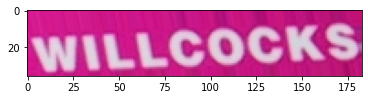

In [11]:
plt.imshow(Image.fromarray(CVRandomAffine(degrees=15, translate=(0.3, 0.3), scale=(0.5, 2.), shear=(45, 15))(np.array(img))))

In [12]:
Image.fromarray(CVRandomAffine(degrees=0, translate=(0.5, 0.5), scale=(1., 1.), shear=(0, 0))(np.array(img2)))

# CVRandomPerspective

In [13]:
class CVRandomPerspective(object):
    def __init__(self, distortion=0.5):
        self.distortion = distortion

    def get_params(self, width, height, distortion):
        offset_h = sample_asym(distortion * height / 2, size=4).astype(dtype=np.int)
        offset_w = sample_asym(distortion * width / 2, size=4).astype(dtype=np.int)
        topleft  = (            offset_w[0],              offset_h[0])
        topright = (width - 1 - offset_w[1],              offset_h[1])
        botright = (width - 1 - offset_w[2], height - 1 - offset_h[2])
        botleft  = (            offset_w[3], height - 1 - offset_h[3])

        startpoints = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)]
        endpoints = [topleft, topright, botright, botleft]
        return np.array(startpoints, dtype=np.float32), np.array(endpoints, dtype=np.float32)
    
    def __call__(self, img):
        height, width = img.shape[:2]
        startpoints, endpoints = self.get_params(width, height, self.distortion)
        M = cv2.getPerspectiveTransform(startpoints, endpoints)

        # TODO: more robust way to crop image
        rect = cv2.minAreaRect(endpoints)
        bbox = cv2.boxPoints(rect).astype(dtype=np.int)
        max_x, max_y = bbox[:, 0].max(), bbox[:, 1].max()
        min_x, min_y = bbox[:, 0].min(), bbox[:, 1].min()
        min_x, min_y = max(min_x, 0), max(min_y, 0)

        flags = get_interpolation() 
        img = cv2.warpPerspective(img, M, (max_x, max_y), flags=flags, borderMode=cv2.BORDER_REPLICATE)
        img = img[min_y:, min_x:]
        return img

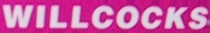

In [14]:
Image.fromarray(CVRandomPerspective()(np.array(img)))

In [15]:
Image.fromarray(CVRandomPerspective()(np.array(img2)))

# Deterioration transformation

# CVRescale

In [16]:
class CVRescale(object):
    
    def __init__(self, factor=4, base_size=(128, 512)):
        """ Define image scales using gaussian pyramid and rescale image to target scale.
        
        Args:
            factor: the decayed factor from base size, factor=4 keeps target scale by default.
            base_size: base size the build the bottom layer of pyramid
        """
        if isinstance(factor, numbers.Number):
            self.factor = round(sample_uniform(0, factor))
        elif isinstance(factor, (tuple, list)) and len(factor) == 2:
            self.factor = round(sample_uniform(factor[0], factor[1]))
        else:
            raise Exception('factor must be number or list with length 2')
        # assert factor is valid
        self.base_h, self.base_w = base_size[:2]

    def __call__(self, img):
        if self.factor == 0: return img
            
        src_h, src_w = img.shape[:2]
        cur_w, cur_h = self.base_w, self.base_h        
        scale_img = cv2.resize(img, (cur_w, cur_h), interpolation=get_interpolation())
        for _ in range(self.factor): 
            scale_img = cv2.pyrDown(scale_img)
        scale_img = cv2.resize(scale_img, (src_w, src_h), interpolation=get_interpolation())
        return scale_img

In [17]:
def test_rescale(img, factor=5):
    test_img = np.array(img)
    scale_img = CVRescale(factor)(test_img)
    plt.subplot(1, 2, 1)
    plt.imshow(scale_img)
    resize_img = cv2.resize(scale_img, (128, 32))
    plt.subplot(1, 2, 2)
    plt.imshow(resize_img)

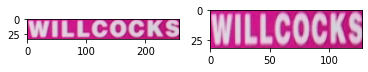

In [18]:
test_rescale(img, factor=[0,0])

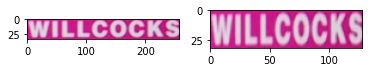

In [19]:
test_rescale(img, factor=[1,1])

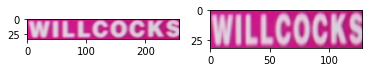

In [20]:
test_rescale(img, factor=[2,2])

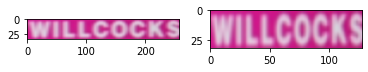

In [21]:
test_rescale(img, factor=[3,3])

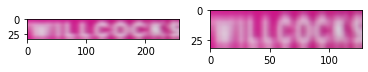

In [22]:
test_rescale(img, factor=[4,4])

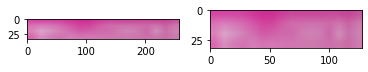

In [23]:
test_rescale(img, factor=[5,5])

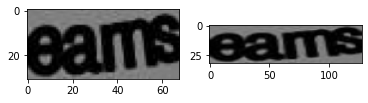

In [24]:
test_rescale(img2, [0,0])

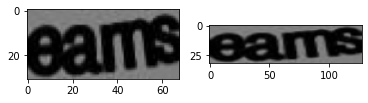

In [25]:
test_rescale(img2, [1,1])

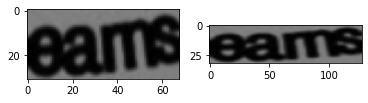

In [26]:
test_rescale(img2, [2,2])

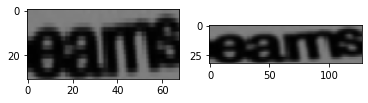

In [27]:
test_rescale(img2, [3,3])

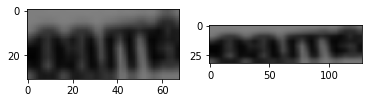

In [28]:
test_rescale(img2, [4,4])

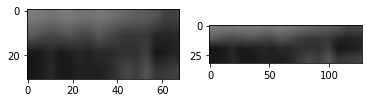

In [29]:
test_rescale(img2, [5,5])

# CVGaussianNoise

In [30]:
class CVGaussianNoise(object):
    def __init__(self, mean=0, var=20):
        self.mean = mean
        if isinstance(var, numbers.Number):
            self.var = max(int(sample_asym(var)), 1)
        elif isinstance(var, (tuple, list)) and len(var) == 2:
            self.var = int(sample_uniform(var[0], var[1]))
        else:
            raise Exception('degree must be number or list with length 2')
        
    def __call__(self, img):
        noise = np.random.normal(self.mean, self.var**0.5, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)
        return img

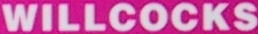

In [31]:
Image.fromarray(CVGaussianNoise(var=0)(np.array(img)))

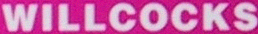

In [32]:
Image.fromarray(CVGaussianNoise(var=(20, 20))(np.array(img)))

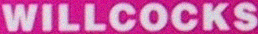

In [33]:
Image.fromarray(CVGaussianNoise(var=(80,80))(np.array(img)))

In [34]:
Image.fromarray(CVGaussianNoise()(np.array(img2)))

# CVMotionBlur

In [35]:
class CVMotionBlur(object):
    def __init__(self, degrees=12, angle=90):
        if isinstance(degrees, numbers.Number):
            self.degree = max(int(sample_asym(degrees)), 1)
        elif isinstance(degrees, (tuple, list)) and len(degrees) == 2:
            self.degree = int(sample_uniform(degrees[0], degrees[1]))
        else:
            raise Exception('degree must be number of list with length 2')
        self.angle = sample_uniform(-angle, angle)

    def __call__(self, img):
        M = cv2.getRotationMatrix2D((self.degree // 2, self.degree // 2), self.angle, 1)
        motion_blur_kernel = np.zeros((self.degree, self.degree))
        motion_blur_kernel[self.degree // 2, :] = 1
        motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (self.degree, self.degree))
        motion_blur_kernel = motion_blur_kernel / self.degree
        img = cv2.filter2D(img, -1, motion_blur_kernel)
        img = np.clip(img, 0, 255).astype(np.uint8)
        return img

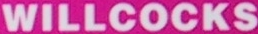

In [36]:
Image.fromarray(CVMotionBlur()(np.array(img)))

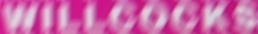

In [37]:
Image.fromarray(CVMotionBlur(degrees=(15,15))(np.array(img)))

In [38]:
Image.fromarray(CVMotionBlur()(np.array(img2)))

# Ensemble

In [39]:
class CVGeometry(object):
    def __init__(self, degrees=15, translate=(0.3, 0.3), scale=(0.5, 2.), shear=(45, 15), distortion=0.5):
        p = np.random.rand()
        if p < 0.33:
            self.transforms = CVRandomRotation(degrees=degrees)
        elif p < 0.66:
            self.transforms = CVRandomAffine(degrees=degrees, translate=translate, scale=scale, shear=shear)
        else:
            self.transforms = CVRandomPerspective(distortion=distortion)

    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(self.transforms(img))

class CVDeterioration(object):
    def __init__(self, var, degrees, factor):
        transforms = []
        if var is not None:
            transforms.append(CVGaussianNoise(var=var))
        if degrees is not None:
            transforms.append(CVMotionBlur(degrees=degrees))
        if factor is not None:
            transforms.append(CVRescale(factor=factor))
            
        random.shuffle(transforms)
        transforms = Compose(transforms)
        self.transforms =  transforms
        
    def __call__(self, img):
        img = np.array(img)
        return Image.fromarray(self.transforms(img))

# Resize

In [40]:
class CVResize(object):
    def __init__(self, dst_h, dst_w, is_training=False):
        self.img_w, self.img_h = dst_w, dst_h
        self.is_training = is_training
        
    def __call__(self, img):
        img = np.array(img)
        target_ratio = self.img_w / self.img_h
        ratio = img.shape[1] / img.shape[0]
        if ratio > target_ratio:
            #target_img_w, target_img_h = self.img_w, int(self.img_w / ratio)  # CASE 1
            target_img_w, target_img_h = self.img_w, self.img_h  # CASE 2
        else:
            target_img_w, target_img_h = int(ratio * self.img_h), self.img_h
        
        inter_method = 'random' if self.is_training else 'linear'
        interpolation = get_interpolation(inter_method)
        img = cv2.resize(img, (target_img_w, target_img_h), interpolation=interpolation)
        
        pad_v = int((self.img_h - target_img_h) / 2)
        pad_h = int((self.img_w - target_img_w) / 2)
        img = cv2.copyMakeBorder(img, pad_v, pad_v, pad_h, pad_h, borderType=cv2.BORDER_REPLICATE)
        return Image.fromarray(img)

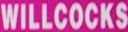

In [41]:
CVResize(32, 128, True)(img)

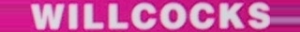

In [42]:
CVResize(32, 300, True)(img)

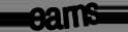

In [43]:
CVResize(32, 128, True)(img2)

# Test 

[b'8*', b'608', b'VIU846', b'*', b'*', b'33', b'*', b'705', b'*', b'Marshalls', b'20TH AV', b'*']


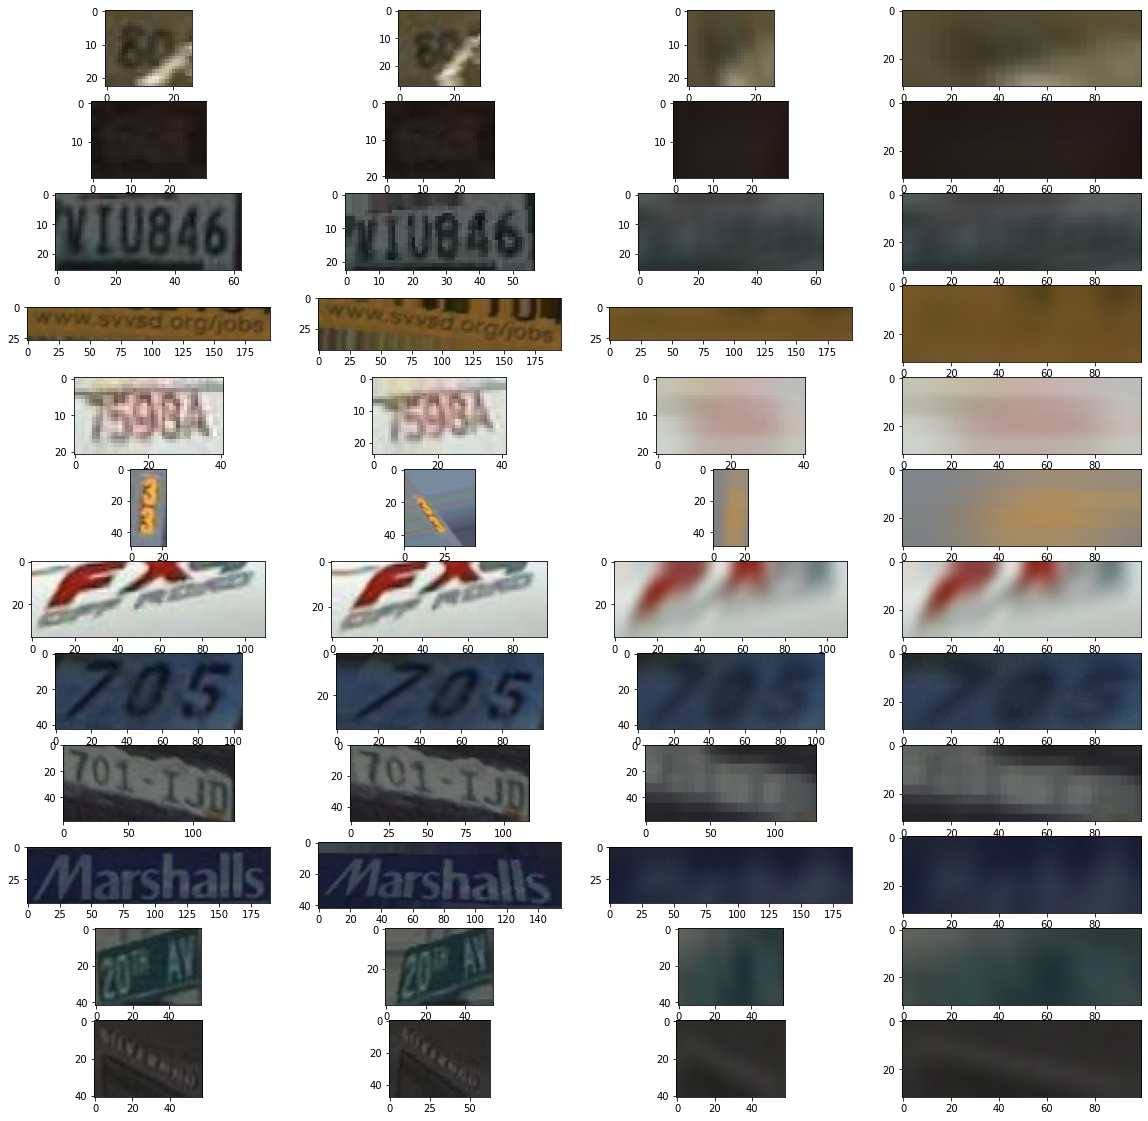

In [48]:
import six
import lmdb

path = '../data/uber-text'
labels = []
plt.figure(figsize=(20,20))
rows, cols = 12, 4
with lmdb.open(str(path), readonly=True, lock=False, readahead=False, meminit=False).begin(write=False) as txn:
    length = int(txn.get('num-samples'.encode()))
    for i in range(rows):
        index = random.randint(0, length-1)
        image_key = f'image-{index+1:09d}'
        label_key = f'label-{index+1:09d}'
        
        imgbuf = txn.get(image_key.encode())
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        x = Image.open(buf).convert('RGB')
        label = txn.get(label_key.encode())
        
        plt.subplot(rows, cols, cols*i+1)
        plt.imshow(x)
        
        x1 = CVGeometry(degrees=15, translate=(0.3, 0.3), scale=(0.5, 2.), shear=(45, 15), distortion=0.5)(x)
        plt.subplot(rows, cols, cols*i+2)
        plt.imshow(x1)       
        
        x2 = CVDeterioration(var=30, degrees=(9,15), factor=(4, 5))(x) # unreadable
        #x2 = CVDeterioration(var=20, degrees=6, factor=4)(x) # readable
        plt.subplot(rows, cols, cols*i+3)
        plt.imshow(x2)
     
        x3 = cv2.resize(np.array(x2), (100, 32), interpolation=get_interpolation())
        plt.subplot(rows, cols, cols*i+4)
        plt.imshow(x3)
        
        labels.append(label)
print(labels)

[b'*****s ***s', b'* ***O ******', b'*', b'Jeep', b'415.445.5136', b'22', b'116', b'DELI', b'MON-SUN', b'*', b'MOUNTAIN SPIRIT', b'*']


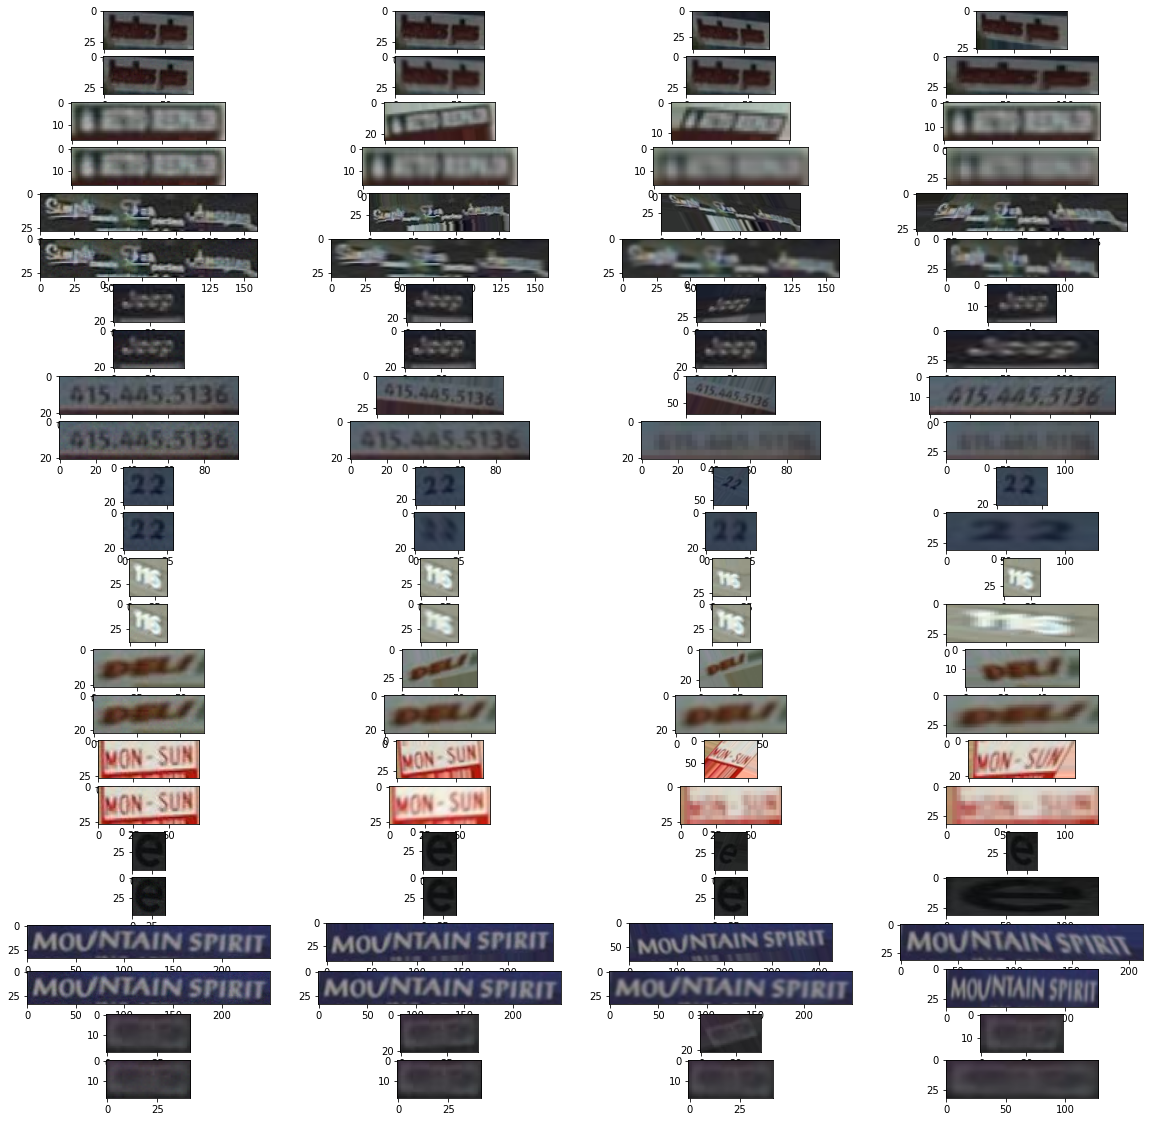

In [45]:
import six
import lmdb

path = '../data/uber-text'
labels = []
plt.figure(figsize=(20,20))
rows, cols = 24, 4
with lmdb.open(str(path), readonly=True, lock=False, readahead=False, meminit=False).begin(write=False) as txn:
    length = int(txn.get('num-samples'.encode()))
    for i in range(rows//2):
        index = random.randint(0, length-1)
        image_key = f'image-{index+1:09d}'
        label_key = f'label-{index+1:09d}'
        
        imgbuf = txn.get(image_key.encode())
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        x = Image.open(buf).convert('RGB')
        label = txn.get(label_key.encode())
        
        x = np.array(x)
        plt.subplot(rows, cols, 2 * cols*i+1)
        plt.imshow(x)        
        
        
        x1 = CVRandomRotation(degrees=15)(x)
        plt.subplot(rows, cols, 2 * cols*i+2)
        plt.imshow(x1)       
        
        x2 = CVRandomAffine(degrees=15, translate=(0.3, 0.3), scale=(0.5, 2.), shear=(45, 15))(x)
        plt.subplot(rows, cols, 2 * cols*i+3)
        plt.imshow(x2)
        
        x3 = CVRandomPerspective(distortion=0.5)(x)
        plt.subplot(rows, cols, 2 * cols*i+4)
        plt.imshow(x3)
     
    
    
        x4 = CVGaussianNoise(var=20)(x)
        plt.subplot(rows, cols, 2 * cols*i+5)
        plt.imshow(x4)
   
        x5 = CVMotionBlur(degrees=12)(x)
        plt.subplot(rows, cols, 2 * cols*i+6)
        plt.imshow(x5)
        
        x6 = CVRescale(factor=5)(x)
        plt.subplot(rows, cols, 2 * cols*i+7)
        plt.imshow(x6)

    
        x7 = cv2.resize(x6, (128, 32), interpolation=get_interpolation())
        plt.subplot(rows, cols, 2 * cols*i+8)
        plt.imshow(x7)
        
        labels.append(label)
print(labels)

# ColorJitter

[b'LEGEND', b'HARAP', b'DEALING', b'MAY', b'3213', b'1000', b'www', b'YOU', b'TOURNESOL', b'TREE', b'WAR', b'radio']


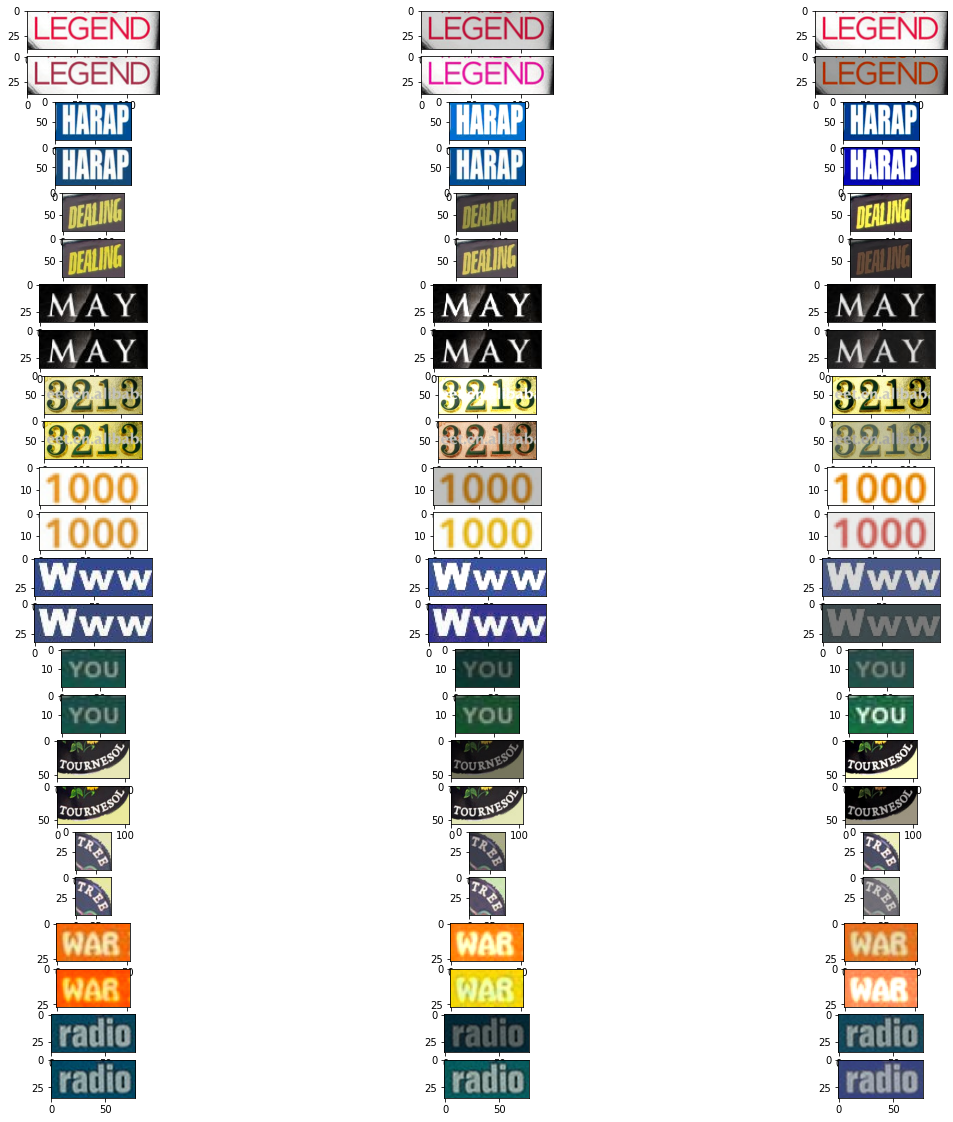

In [46]:
import six
import lmdb
from torchvision.transforms import ColorJitter

#path = '../data/uber-text'
path = '../data/IIIT5K_3000'
labels = []
plt.figure(figsize=(20,20))
rows, cols = 24, 3
with lmdb.open(str(path), readonly=True, lock=False, readahead=False, meminit=False).begin(write=False) as txn:
    length = int(txn.get('num-samples'.encode()))
    for i in range(rows//2):
        index = random.randint(0, length-1)
        image_key = f'image-{index+1:09d}'
        label_key = f'label-{index+1:09d}'
        
        imgbuf = txn.get(image_key.encode())
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        x = Image.open(buf).convert('RGB')
        label = txn.get(label_key.encode())
        
        plt.subplot(rows, cols, 2*cols*i+1)
        plt.imshow(x)
        
        x1 = ColorJitter(brightness=0.5)(x)
        plt.subplot(rows, cols, 2*cols*i+2)
        plt.imshow(x1)    
        
        x2 = ColorJitter(contrast=0.5)(x)
        plt.subplot(rows, cols, 2*cols*i+3)
        plt.imshow(x2)    
        
        x3 = ColorJitter(saturation=0.75)(x)
        plt.subplot(rows, cols, 2*cols*i+4)
        plt.imshow(x3)    
        
        x4 = ColorJitter(hue=0.1)(x)
        plt.subplot(rows, cols, 2*cols*i+5)
        plt.imshow(x4)    
        
        x5 = ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)(x)
        plt.subplot(rows, cols, 2*cols*i+6)
        plt.imshow(x5)
        
        labels.append(label)
print(labels)

# Other

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from scipy.interpolate import UnivariateSpline

In [ ]:
x = np.linspace(-1, 2, 10000)

In [ ]:
pdf = stats.beta(6, 1).pdf(x)
#pdf = stats.norm().pdf(x)
plt.plot(x, pdf)

In [ ]:
from scipy.stats import truncnorm
a = truncnorm.rvs(-2, 2, loc=0, scale=1, size=10)

In [ ]:
a

In [ ]:
mu, sigma = 0, 0.3
lower, upper = mu - 2 * sigma, mu + 2 * sigma  # 截断在[μ-2σ, μ+2σ]
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

plt.hist(X.rvs(size=100000), normed=True, bins=1000)   # 截断正态分布的直方图

In [ ]:
plt.hist(stats.norm.cdf(np.random.normal(loc=0,scale=1.0,size=5000)), normed=True, bins=100)

In [ ]:
plt.hist(np.random.beta(1,2, 1000000), normed=True, bins=100)

In [ ]:
np.random.beta(1, 2, 10) * int(32)

In [ ]:
(np.random.beta(1, 2, 10) * (16)).astype(dtype=np.int)

In [ ]:
(np.random.beta(1, 2, 40) * 20).astype(dtype=np.int)

In [ ]:
import math
math.radians(90)

In [ ]:
np.random.beta(1, 2, 4)

In [ ]:
np.random.beta(1, 2, size=None)

In [ ]:
plt.hist((np.random.beta(2,2, 1000000)-0.5)*2 * 4, normed=True, bins=100)

In [ ]:
get_interpolation('random')

In [ ]:
def rescale(x):
    ssize = src.shape[:2]
    axis = 0 if tsize[1] / tsize[0] > ssize[1] / ssize[0] else 1
    print('axis', axis)
    num_layer = math.ceil(math.log(factor * ssize[axis] / tsize[axis], 2))
    img = x
    for i in range(num_layer):
        img = cv2.pyrDown(img)
    return img

def resize(x):
    choice = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA]
    interpolation = choice[random.randint(0, len(choice)-1)]
    return cv2.resize(x, tsize[::-1], interpolation=interpolation)

def gaussian_noise(x, mean=0, var=10):
    noise = np.random.normal(mean, var**0.5, x.shape)
    x = np.clip(x + noise, 0, 255).astype(np.uint8)
    return x

def motion_blur(x, degree=9, angle=45):
    M = cv2.getRotationMatrix2D((degree / 2, degree / 2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel / degree
    x = cv2.filter2D(x, -1, motion_blur_kernel)
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x

In [ ]:
np.random.uniform(-100, 100, size=4)

In [ ]:
np.random.rand()

In [ ]:
def motion_blur(x, degree=5, angle=90):
    M = cv2.getRotationMatrix2D((degree / 2, degree / 2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel / degree
    print(motion_blur_kernel)
    x = cv2.filter2D(x, -1, motion_blur_kernel)
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x

In [ ]:
motion_blur(np.array(img))

In [ ]:
np.random.rand(10)

In [62]:
import time
s = time.time()
num = 256
for i in range(num):
    CVRescale(factor=(5,5))(np.array(img))
print((time.time() - s)/num)
print((time.time() - s))

0.0009006913751363754
0.23082304000854492


In [68]:
import time
s = time.time()
num = 256
for i in range(num):
    CVRescale(factor=4)(np.array(img))
print((time.time() - s)/num)
print((time.time() - s))

0.0007139602676033974
0.18315553665161133
